# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.2 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load FBM myeloid lineage

In [3]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20200414.h5ad')

In [4]:
adata.raw = adata

In [5]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CAR                          365
CD4 T                        327
CD8 T                        171
CD14 monocyte               8787
CD56 bright NK               540
CMP                          425
DC1                           50
DC2                          598
DC3                          705
DC precursor                 201
ELP                         1358
GMP                         1285
HSC                           92
ILC precursor                 67
Immature B cell             1998
MEMP                          16
MEP                          269
MK                          1036
MPP lymphoid                  34
MPP myeloid 1                 46
MPP myeloid 2                 46
NKT                          137
Naive B cell                1423
Pre B progenitor           14234
Pre pro B progenitor        5428
Pro B progenitor            5530
Treg                          62
basophil                     139
chondrocyte                   72
chondrocyte precursor        16

In [6]:
myeloid_celltypes = ["basophil", "CD14 monocyte", "CMP", "DC precursor", "DC1", "DC2", "DC3", "eo/baso/mast precursor", "eosinophil", "GMP", "mast cell", "monocyte precursor", "myelocyte", "myeloid DC progenitor", "neut myeloid", "neutrophil", "pDC", "pDC progenitor", "promyelocyte", "tDC"]

In [7]:
adata = adata[adata.obs['cell.labels'].isin(myeloid_celltypes)].copy()

In [8]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD14 monocyte             8787
CMP                        425
DC1                         50
DC2                        598
DC3                        705
DC precursor               201
GMP                       1285
basophil                   139
eo/baso/mast precursor     175
eosinophil                 325
mast cell                  648
monocyte precursor        7946
myelocyte                 3854
myeloid DC progenitor       31
neut myeloid              4184
neutrophil                4516
pDC                        713
pDC progenitor              23
promyelocyte              1922
tDC                        193
dtype: int64

In [9]:
adata.shape

(36720, 33712)

# Pre-process the dataset

In [10]:
# normalise count data 
sc.pp.normalize_total(adata)

In [11]:
# log the count data 
sc.pp.log1p(adata)

In [12]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [13]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [14]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0, adata.X)

In [15]:
# run pca
sc.tl.pca(adata, n_comps=50)

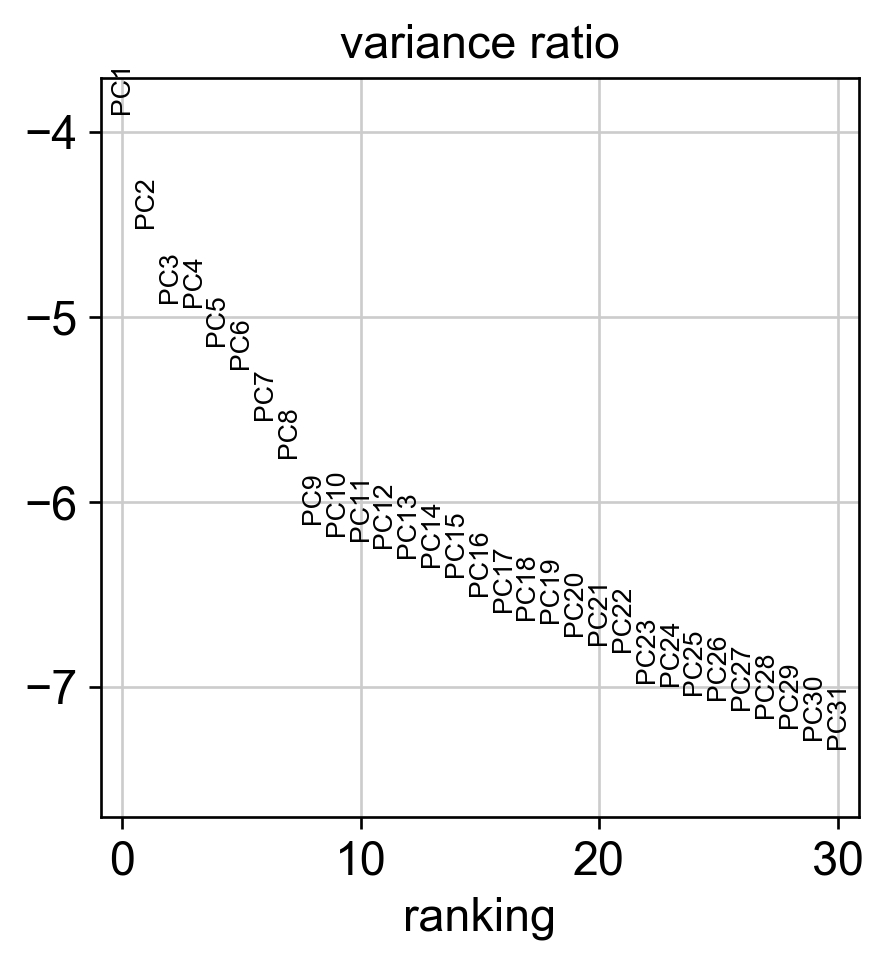

In [16]:
# have a look at pc's in order to choose number of pcs that will be used downstream 
sc.pl.pca_variance_ratio(adata, log=True)

In [17]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10) 

In [18]:
# run umap
sc.tl.umap(adata) 

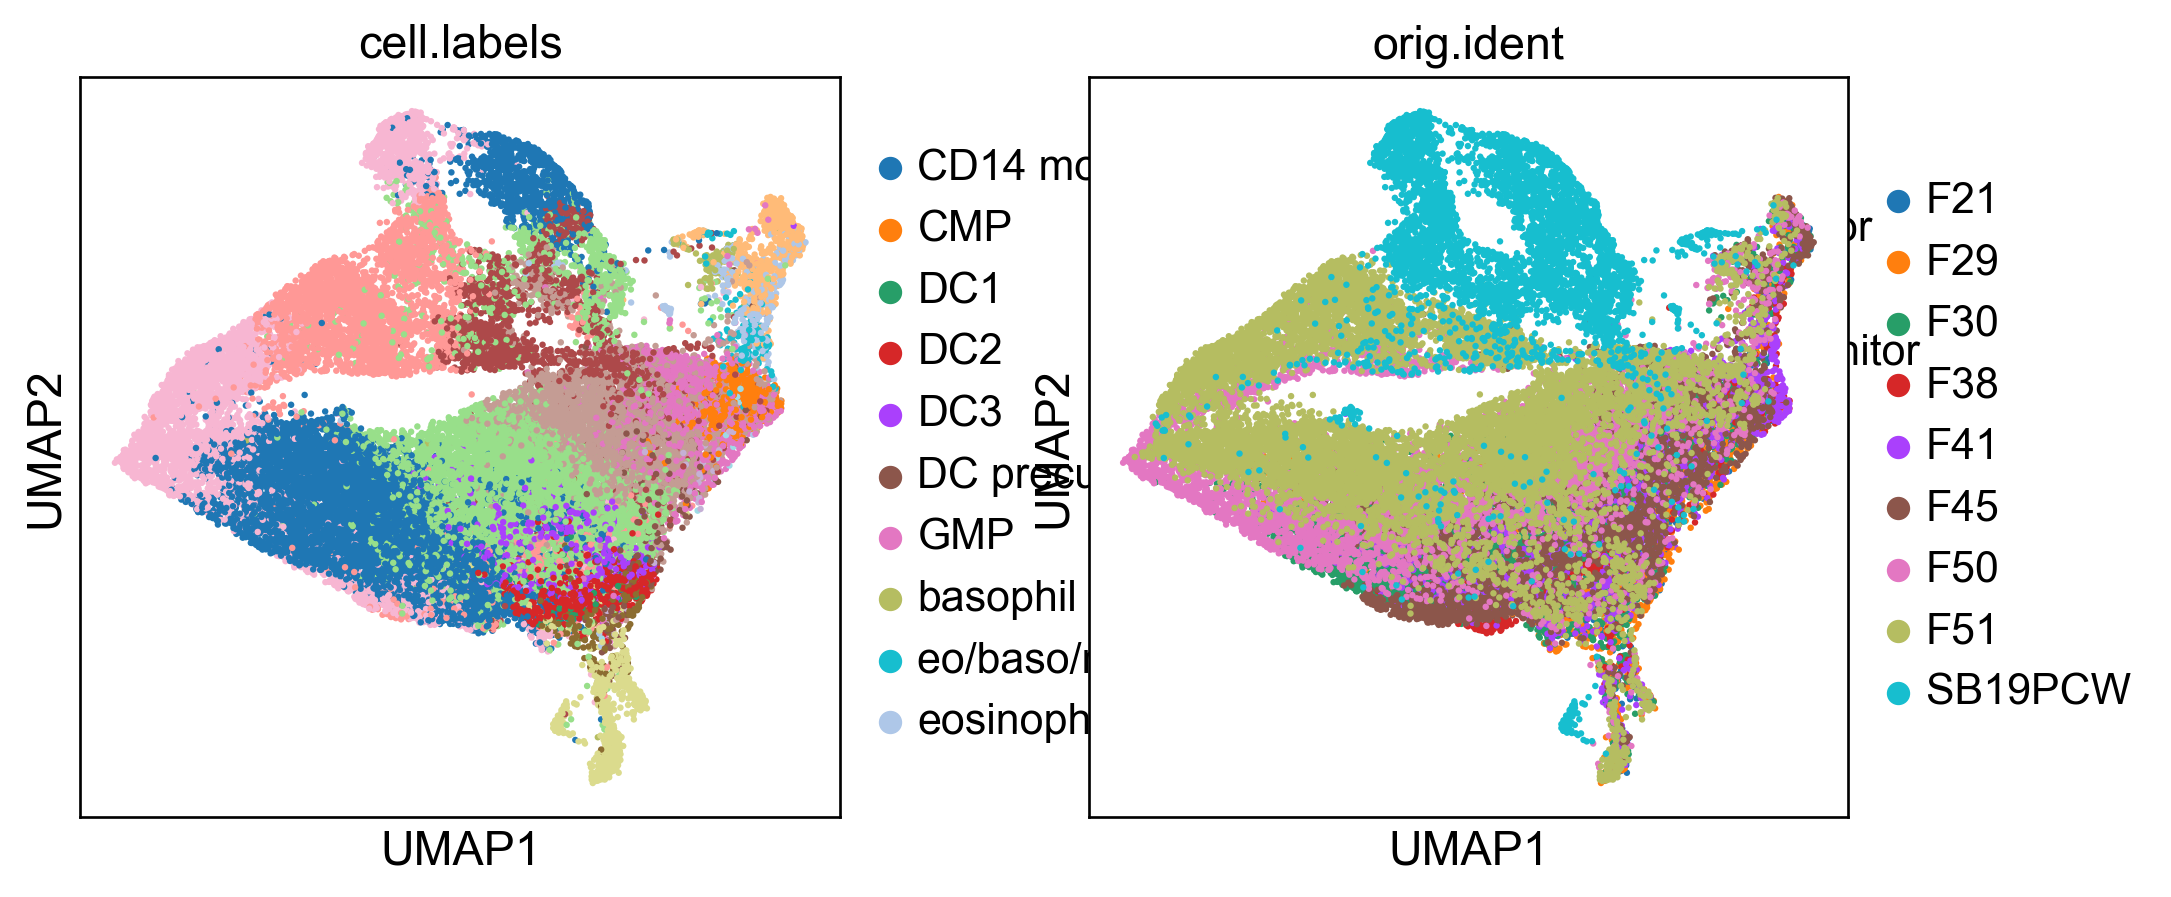

In [19]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

# Run harmony batch correction

In [20]:
#harmony prep - save pca and batch (sample) metadata columns 
pca = adata.obsm['X_pca']
batch = adata.obs['orig.ident']

In [21]:
# load up harmony in rpy2
%load_ext rpy2.ipython

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [22]:
%%R -i pca -i batch -o hem

library(harmony)
library(magrittr)

hem = HarmonyMatrix(pca, batch, theta=3, verbose=TRUE, do_pca=FALSE)
hem = data.frame(hem)

R[write to console]: Loading required package: Rcpp

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

In [23]:
# save old pca values or orig.pca and save batch corrected pca results in anndata object as x_pca
adata.obsm['X_orig_pca'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = hem.values

# Add dimensional reduction post-harmony

In [24]:
# run snn neighbourhood graph
sc.pp.neighbors(adata, n_neighbors=40, n_pcs=10) 

In [25]:
# run umap
sc.tl.umap(adata)

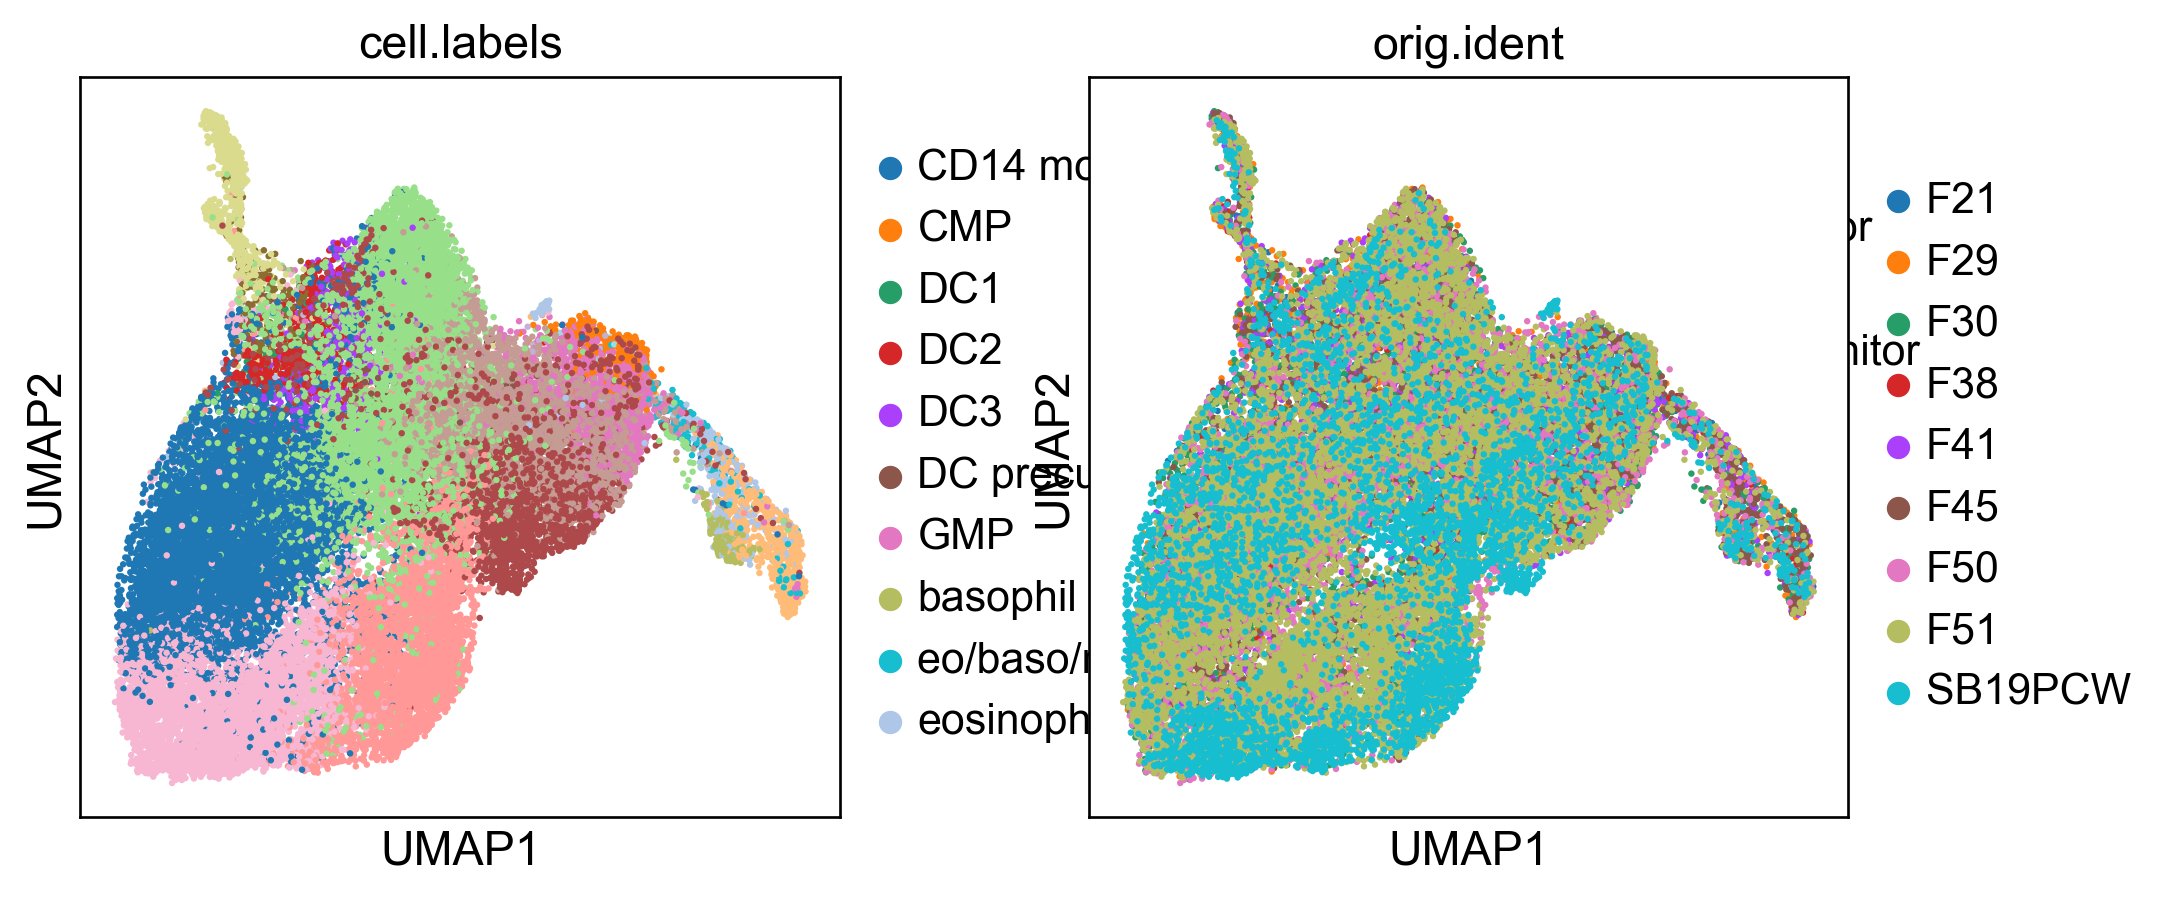

In [26]:
sc.pl.umap(adata, color=['cell.labels', 'orig.ident'], size=15) 

# Change the colours for the myeloid lineage

In [27]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['CD14 monocyte', 'CMP', 'DC1', 'DC2', 'DC3', 'DC precursor', 'GMP',
       'basophil', 'eo/baso/mast precursor', 'eosinophil', 'mast cell',
       'monocyte precursor', 'myelocyte', 'myeloid DC progenitor',
       'neut myeloid', 'neutrophil', 'pDC', 'pDC progenitor', 'promyelocyte',
       'tDC'],
      dtype='object')

In [28]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].cat.reorder_categories(["CMP", 
                        "GMP", "neut myeloid", "eo/baso/mast precursor", "eosinophil", "mast cell", "basophil",    
                        "promyelocyte", "myelocyte", "neutrophil", 
                        "pDC progenitor", "pDC", "tDC", "myeloid DC progenitor",
                        "DC precursor", "DC1", "DC2", "DC3",
                        "monocyte precursor", "CD14 monocyte"])

In [29]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['CMP', 'GMP', 'neut myeloid', 'eo/baso/mast precursor', 'eosinophil',
       'mast cell', 'basophil', 'promyelocyte', 'myelocyte', 'neutrophil',
       'pDC progenitor', 'pDC', 'tDC', 'myeloid DC progenitor', 'DC precursor',
       'DC1', 'DC2', 'DC3', 'monocyte precursor', 'CD14 monocyte'],
      dtype='object')

In [30]:
adata.obs["cell.labels"].cat.categories[2]

'neut myeloid'

In [31]:
new_colors = np.array(adata.uns["cell.labels_colors"])

new_colors[[0]] = '#2B3990' # CMP 
new_colors[[1]] = '#00b5e0' # GMP 
new_colors[[2]] = '#9cf8f0' # neut myeloid 
new_colors[[3]] = '#800080' # eo/baso/mast precursor 
new_colors[[4]] = '#d200d2' # eosinophil 
new_colors[[5]] = '#ff4fff' # basophil 
new_colors[[6]] = '#ffb3ff' # mast cell 
new_colors[[7]] = '#e00018' # promyelocyte 
new_colors[[8]] = '#ff9090' # myelocyte #FFF200
new_colors[[9]] = '#a9a900'  # neutrophil
new_colors[[10]] = '#6d2633' # pDC progenitor
new_colors[[11]] = '#a93c4f' # pDC
new_colors[[12]] = '#d68a98' # tDC 
new_colors[[13]] = '#d200d2' # myeloid DC progenitor
new_colors[[14]] = '#ff6cff' # DC precursor 
new_colors[[15]] = '#a26500' # DC1
new_colors[[16]] = '#e89300' # DC2
new_colors[[17]] = '#ffc055' # DC3
new_colors[[18]] = '#00a900' # monocyte precursor
new_colors[[19]] = '#00fb00' # CD14 monocyte

adata.uns["cell.labels_colors"] = new_colors

new_colors

array(['#2B3990', '#00b5e0', '#9cf8f0', '#800080', '#d200d2', '#ff4fff',
       '#ffb3ff', '#e00018', '#ff9090', '#a9a900', '#6d2633', '#a93c4f',
       '#d68a98', '#d200d2', '#ff6cff', '#a26500', '#e89300', '#ffc055',
       '#00a900', '#00fb00'], dtype='<U7')

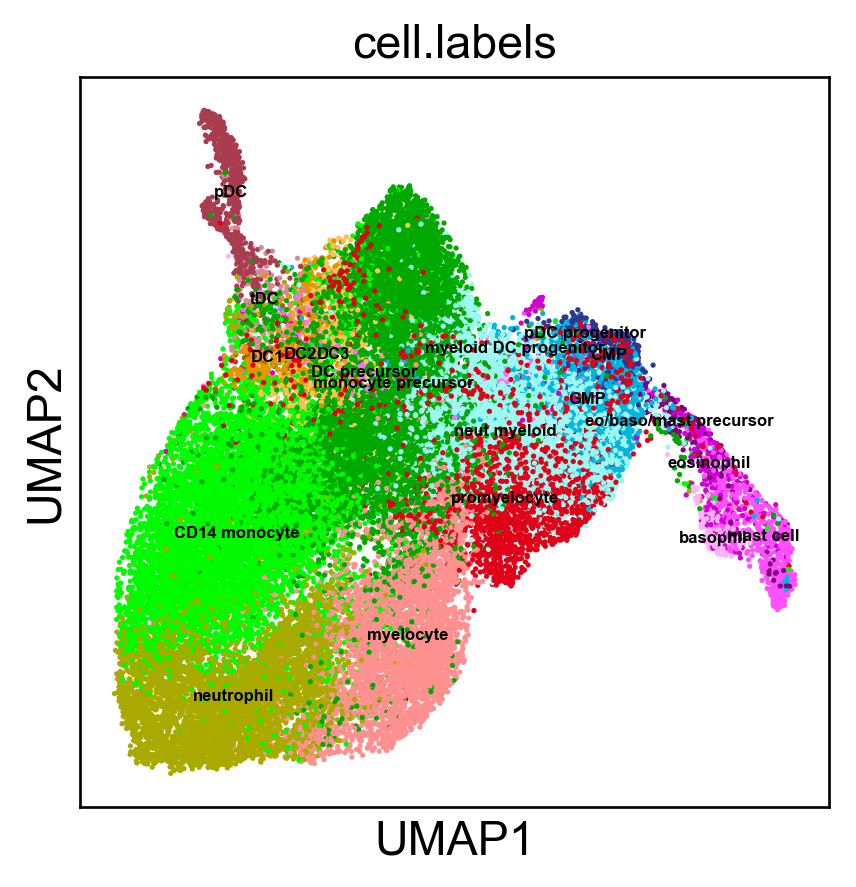

In [32]:
sc.pl.umap(adata, color=['cell.labels'], size=10, legend_loc="on data", legend_fontsize=5) 

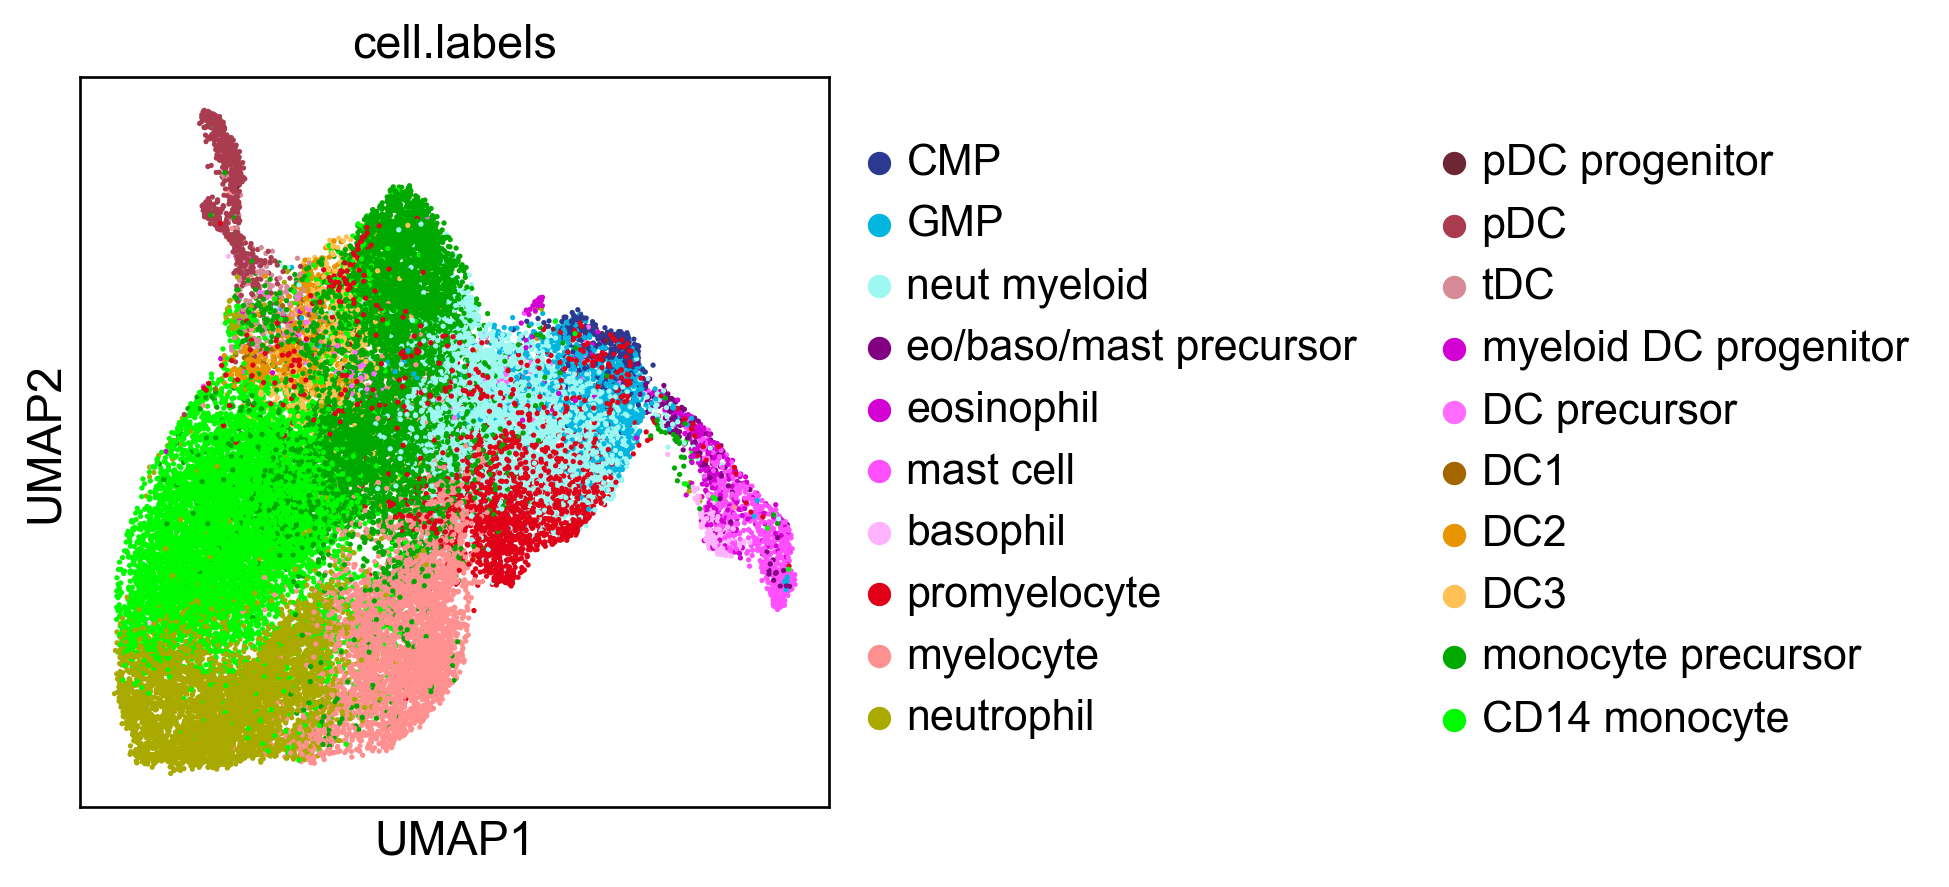

In [33]:
sc.pl.umap(adata, color=['cell.labels'], size=10) 

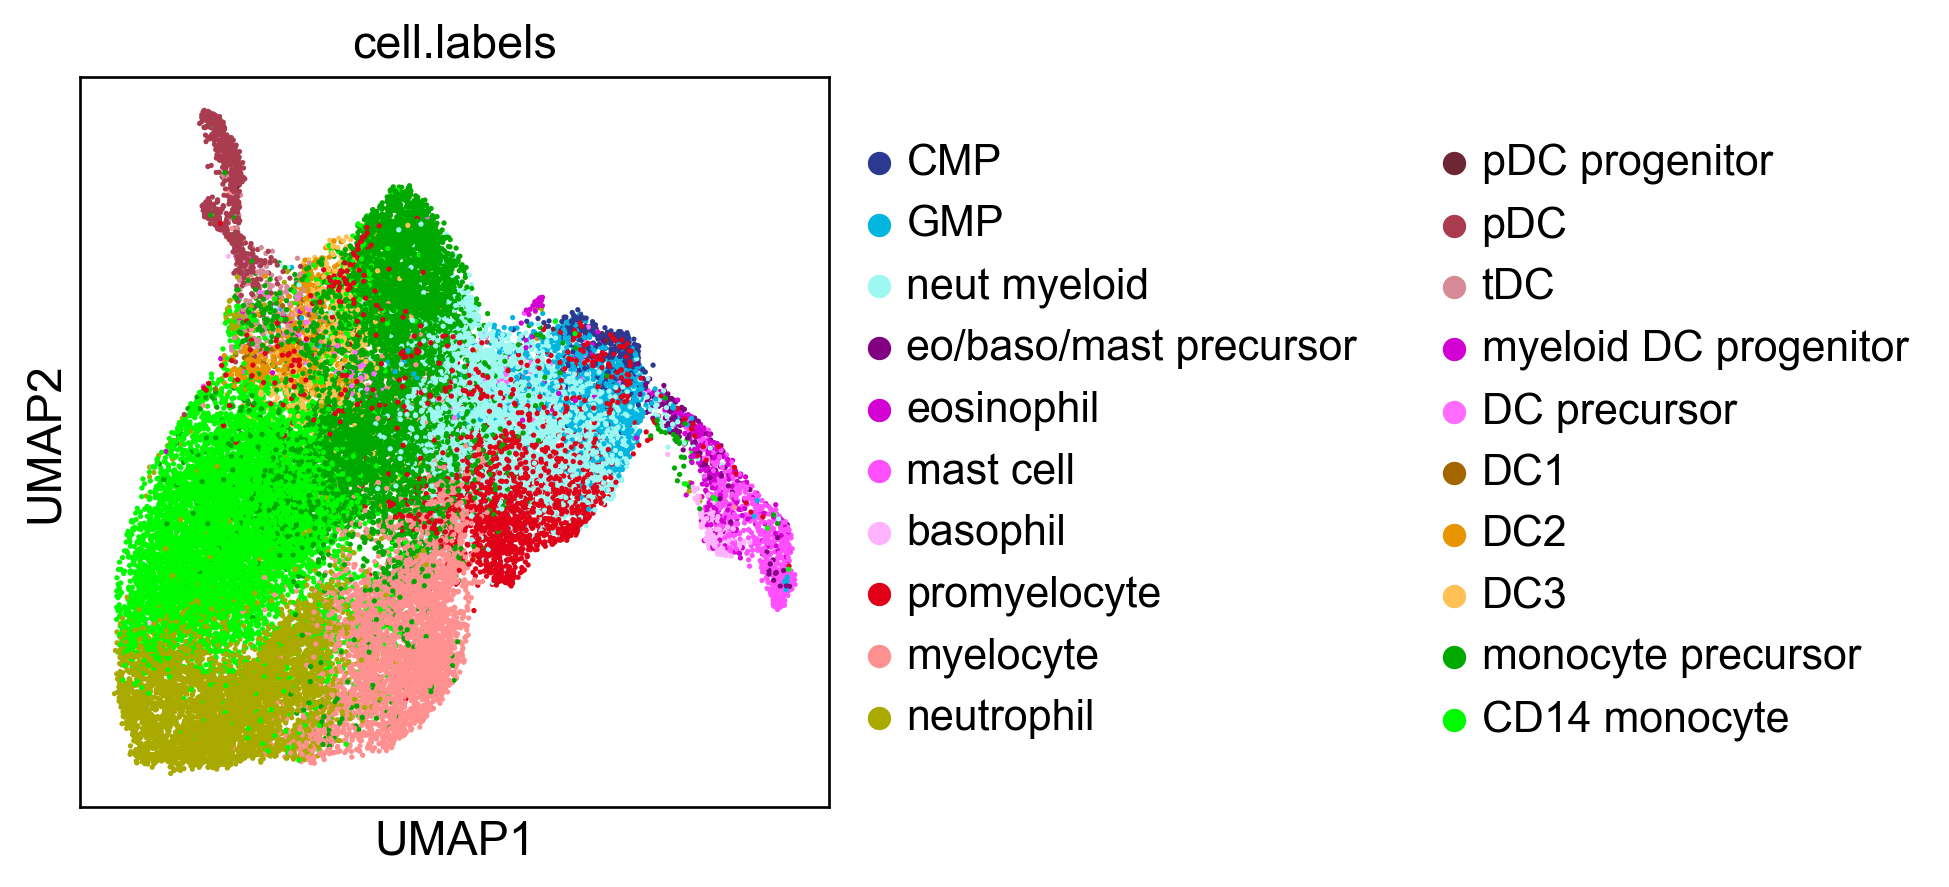

In [34]:
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.pl.umap(adata, color=['cell.labels'], size=10, save="fig2a_myeloid_umap_20200416.pdf") 

# Save the data

In [35]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [36]:
adata.X

<36720x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 70376998 stored elements in Compressed Sparse Row format>

In [37]:
adata.raw.X

<36720x33712 sparse matrix of type '<class 'numpy.float32'>'
	with 76470661 stored elements in Compressed Sparse Row format>

In [38]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig2a_myeloid_dr_20200416.h5ad")

# Replot with better colours

# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.2 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
adata = sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig2a_myeloid_dr_20200416.h5ad")

# Set the colours for the UMAP

# Change the colours for the myeloid lineage

In [4]:
adata.obs["cell.labels"].cat.categories

Index(['CMP', 'GMP', 'neut myeloid', 'eo/baso/mast precursor', 'eosinophil',
       'mast cell', 'basophil', 'promyelocyte', 'myelocyte', 'neutrophil',
       'pDC progenitor', 'pDC', 'tDC', 'myeloid DC progenitor', 'DC precursor',
       'DC1', 'DC2', 'DC3', 'monocyte precursor', 'CD14 monocyte'],
      dtype='object')

In [5]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['CMP', 'GMP', 'neut myeloid', 'eo/baso/mast precursor', 'eosinophil',
       'mast cell', 'basophil', 'promyelocyte', 'myelocyte', 'neutrophil',
       'pDC progenitor', 'pDC', 'tDC', 'myeloid DC progenitor', 'DC precursor',
       'DC1', 'DC2', 'DC3', 'monocyte precursor', 'CD14 monocyte'],
      dtype='object')

In [6]:
adata.obs["cell.labels"].cat.categories[2]

'neut myeloid'

In [7]:
new_colors = np.array(adata.uns["cell.labels_colors"])

new_colors[[0]] = '#2A3B90' # CMP
new_colors[[1]] = '#00B5E0' # GMP
new_colors[[2]] = '#A9DDDF' # Neut-myeloid
new_colors[[3]] = '#F3C19F' # Eo/baso/mast precursor
new_colors[[4]] = '#791315' # Eosinophil
new_colors[[5]] = '#BB7784' # Mast cell
new_colors[[6]] = '#EE2F24' # Basophil
new_colors[[7]] = '#87288A' # Promyelocyte
new_colors[[8]] = '#AD83BB' # Myelocyte
new_colors[[9]] = '#AAAAD5' # Neutrophil
new_colors[[10]] = '#1B437A' # pDC progenitor
new_colors[[11]] = '#DCADC0' # pDC
new_colors[[12]] = '#D43D6A' # tDC
new_colors[[13]] = '#196F8B' # Myeloid DC progenitor
new_colors[[14]] = '#E6DEC1' # DC precursor
new_colors[[15]] = '#A16728' # DC1
new_colors[[16]] = '#F59771' # DC2
new_colors[[17]] = '#F9F06C' # DC3
new_colors[[18]] = '#81C678' # Monocyte precursor
new_colors[[19]] = '#D1DB94' # CD14 monocyte

adata.uns["cell.labels_colors"] = new_colors

new_colors

array(['#2A3B90', '#00B5E0', '#A9DDDF', '#F3C19F', '#791315', '#BB7784',
       '#EE2F24', '#87288A', '#AD83BB', '#AAAAD5', '#1B437A', '#DCADC0',
       '#D43D6A', '#196F8B', '#E6DEC1', '#A16728', '#F59771', '#F9F06C',
       '#81C678', '#D1DB94'], dtype=object)

# Run UMAPs

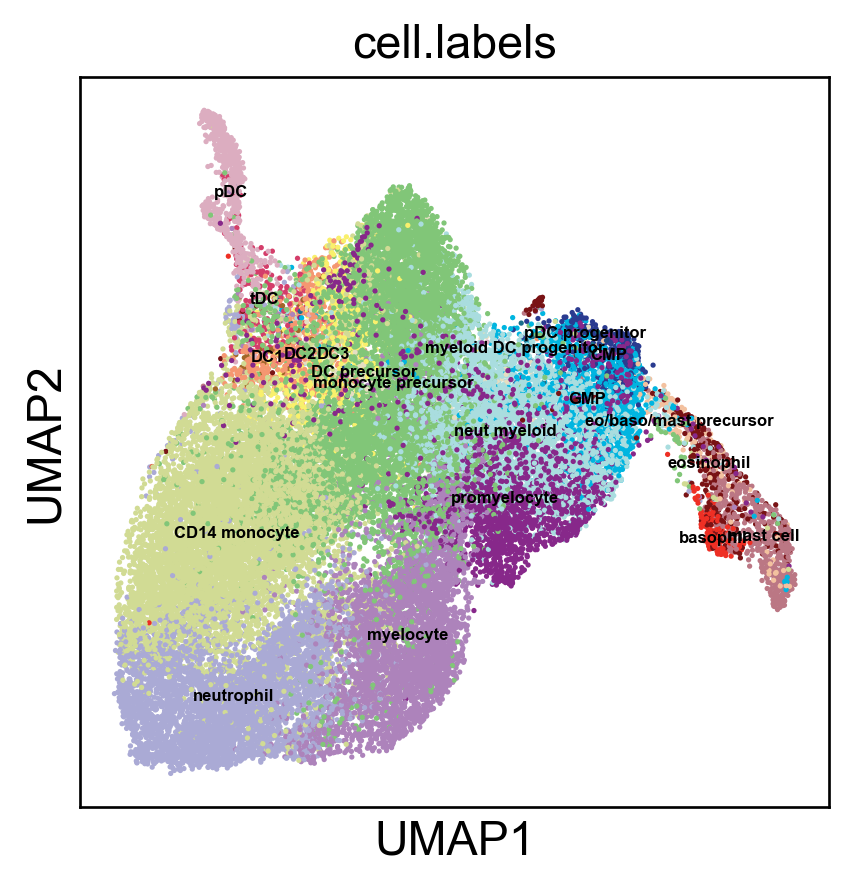

In [8]:
sc.pl.umap(adata, color=['cell.labels'], size=10, legend_loc="on data", legend_fontsize=5) 

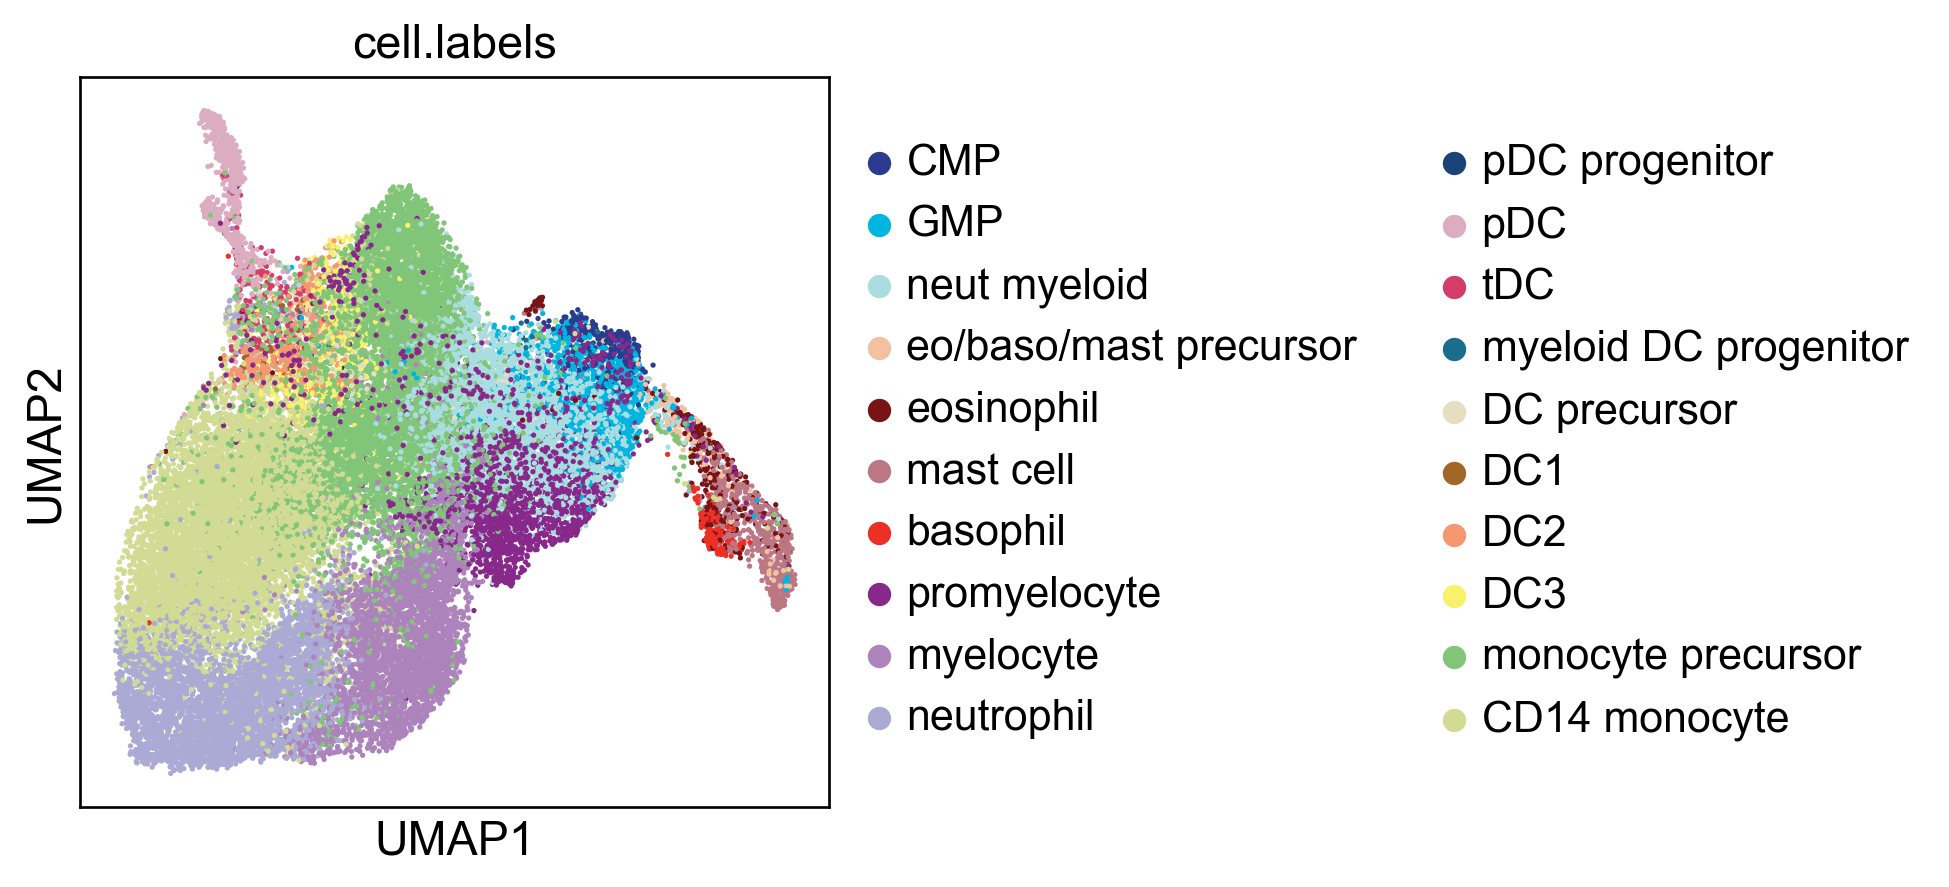

In [13]:
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.pl.umap(adata, color=['cell.labels'], size=10, save="fig2a_umap_myeloid_20200513_v3.pdf") 

# Run an FDG too

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')
# silence NumbaPerformanceWarning
import warnings
from numba.errors import NumbaPerformanceWarning
warnings.filterwarnings("ignore", category=NumbaPerformanceWarning)

In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==0.25.1 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
adata=sc.read("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig2a_myeloid_dr_20200416.h5ad")

# Change the colours for the myeloid lineage

In [4]:
adata.obs["cell.labels"].cat.categories

Index(['CMP', 'GMP', 'neut myeloid', 'eo/baso/mast precursor', 'eosinophil',
       'mast cell', 'basophil', 'promyelocyte', 'myelocyte', 'neutrophil',
       'pDC progenitor', 'pDC', 'tDC', 'myeloid DC progenitor', 'DC precursor',
       'DC1', 'DC2', 'DC3', 'monocyte precursor', 'CD14 monocyte'],
      dtype='object')

In [5]:
adata.obs["cell.labels"] = adata.obs["cell.labels"].astype('category')
adata.obs["cell.labels"].cat.categories

Index(['CMP', 'GMP', 'neut myeloid', 'eo/baso/mast precursor', 'eosinophil',
       'mast cell', 'basophil', 'promyelocyte', 'myelocyte', 'neutrophil',
       'pDC progenitor', 'pDC', 'tDC', 'myeloid DC progenitor', 'DC precursor',
       'DC1', 'DC2', 'DC3', 'monocyte precursor', 'CD14 monocyte'],
      dtype='object')

In [6]:
adata.obs["cell.labels"].cat.categories[2]

'neut myeloid'

In [7]:
new_colors = np.array(adata.uns["cell.labels_colors"])

new_colors[[0]] = '#2A3B90' # CMP
new_colors[[1]] = '#00B5E0' # GMP
new_colors[[2]] = '#A9DDDF' # Neut-myeloid
new_colors[[3]] = '#F3C19F' # Eo/baso/mast precursor
new_colors[[4]] = '#791315' # Eosinophil
new_colors[[5]] = '#BB7784' # Mast cell
new_colors[[6]] = '#EE2F24' # Basophil
new_colors[[7]] = '#87288A' # Promyelocyte
new_colors[[8]] = '#AD83BB' # Myelocyte
new_colors[[9]] = '#AAAAD5' # Neutrophil
new_colors[[10]] = '#1B437A' # pDC progenitor
new_colors[[11]] = '#DCADC0' # pDC
new_colors[[12]] = '#D43D6A' # tDC
new_colors[[13]] = '#196F8B' # Myeloid DC progenitor
new_colors[[14]] = '#E6DEC1' # DC precursor
new_colors[[15]] = '#A16728' # DC1
new_colors[[16]] = '#F59771' # DC2
new_colors[[17]] = '#F9F06C' # DC3
new_colors[[18]] = '#81C678' # Monocyte precursor
new_colors[[19]] = '#D1DB94' # CD14 monocyte

adata.uns["cell.labels_colors"] = new_colors

new_colors

array(['#2A3B90', '#00B5E0', '#A9DDDF', '#F3C19F', '#791315', '#BB7784',
       '#EE2F24', '#87288A', '#AD83BB', '#AAAAD5', '#1B437A', '#DCADC0',
       '#D43D6A', '#196F8B', '#E6DEC1', '#A16728', '#F59771', '#F9F06C',
       '#81C678', '#D1DB94'], dtype=object)

# Run FDG

In [8]:
# run fdg 
# As an input, FDG requires PCA coordinates and a snn graph. must redo snn graph if re-running fdg on subsets 
sc.tl.draw_graph(adata, init_pos='X_pca', layout='fa')

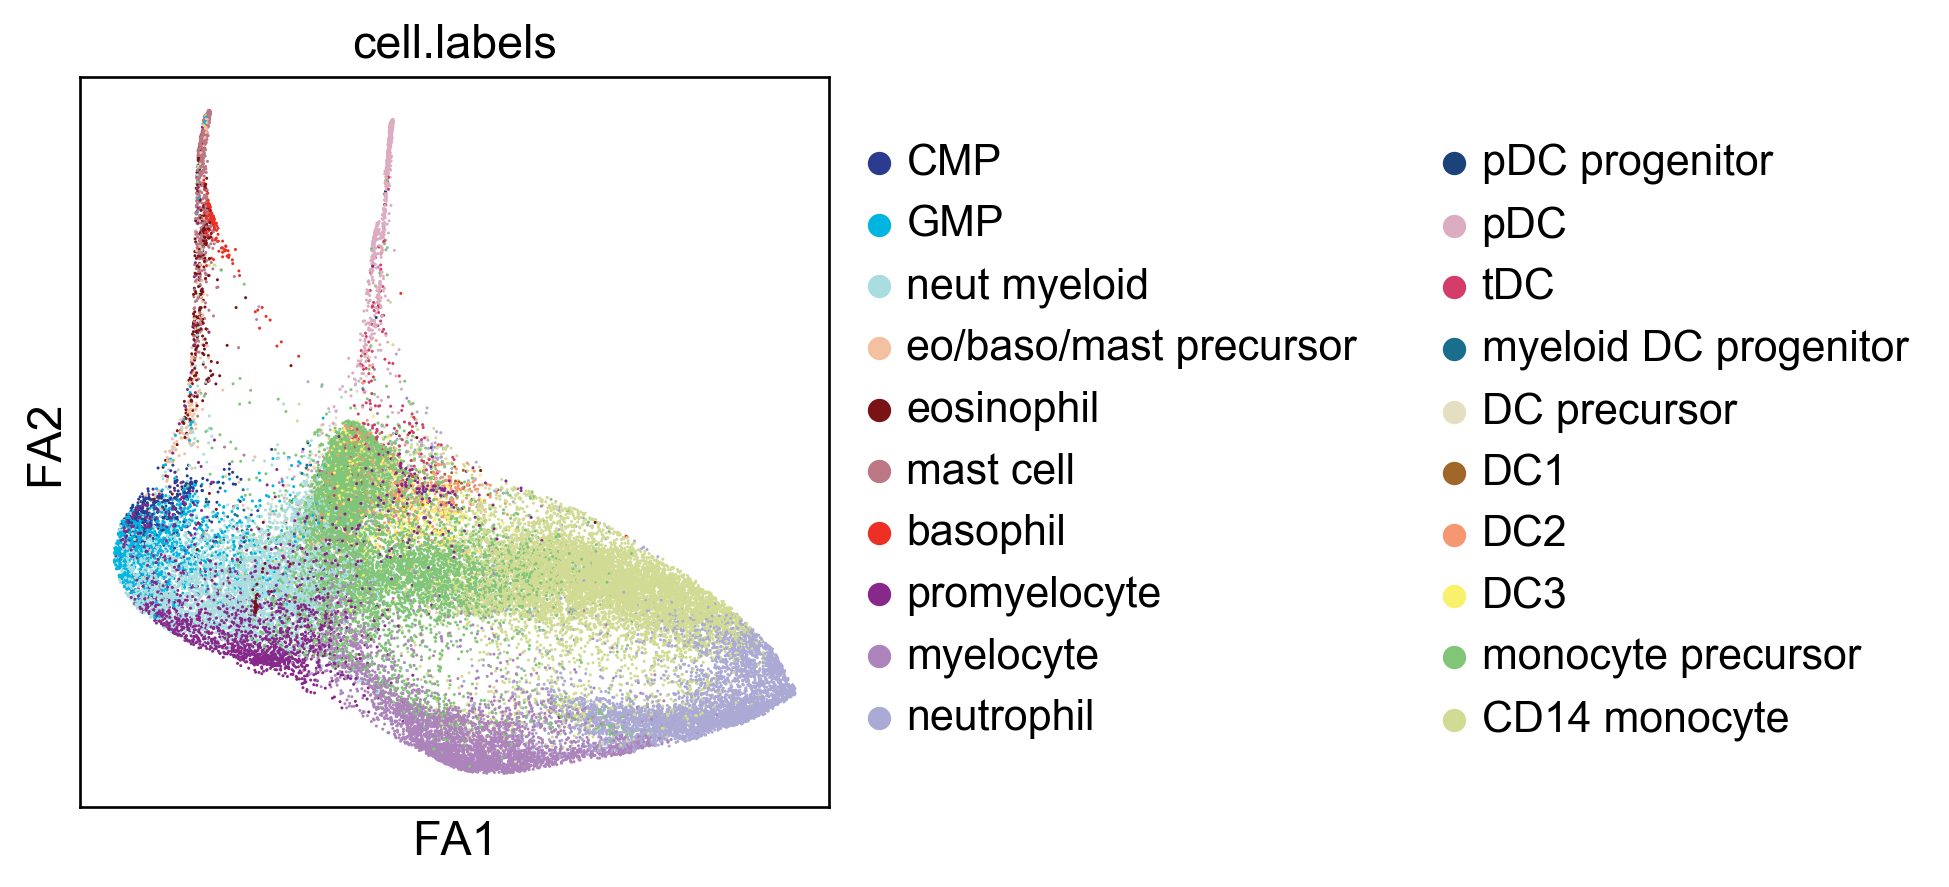

In [9]:
sc.pl.draw_graph(adata, color='cell.labels', layout='fa') #  show=False, save='_myeloid_pre-harmony_cell_labels_legoff.pdf'

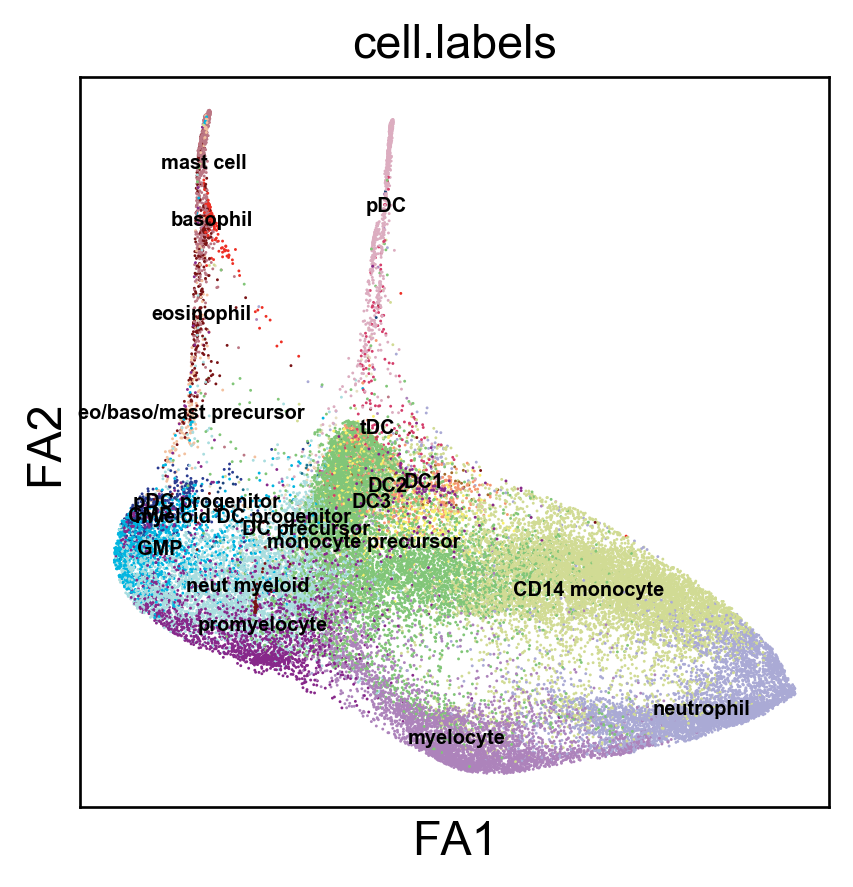

In [12]:
sc.pl.draw_graph(adata, color='cell.labels', layout='fa', legend_loc="on data", legend_fontsize=6, size=3) #  show=False, save='_myeloid_pre-harmony_cell_labels_legoff.pdf'

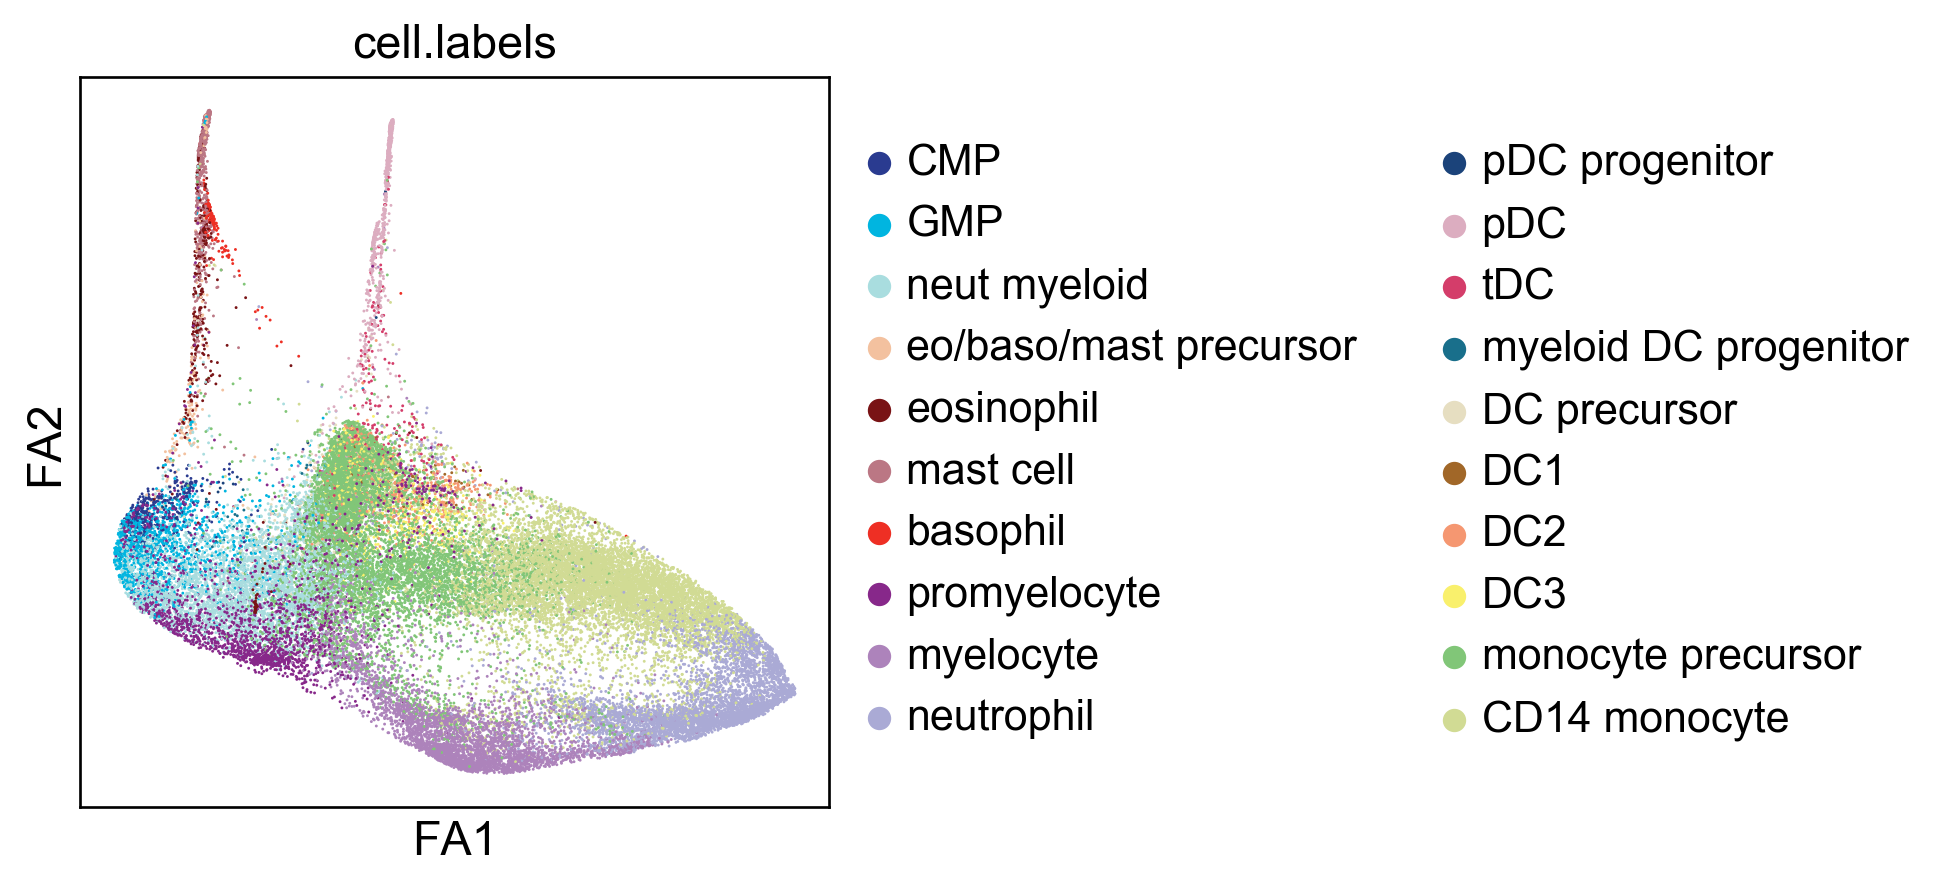

In [13]:
sc.pl.draw_graph(adata, color='cell.labels', layout='fa', size=3, show=True, 
                 save='_fig2a_myeloid_cell_labels_legoff_20200602.pdf')